1. se instalan las dependencias

In [9]:
# !pip list

In [68]:
import tensorflow as tf
import os
tf.compat.v1.reset_default_graph()

In [69]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. se limpian las imágenes

In [70]:
import cv2
import imghdr

In [71]:

data_dir = 'data/'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [72]:
# here we clean our images directory
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

 3. Cargamos la data

In [73]:
tf.data.Dataset?

In [74]:
import numpy as np
from matplotlib import pyplot as plt

In [75]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 17760 files belonging to 2 classes.


In [76]:
data_iterator = data.as_numpy_iterator()

In [77]:
# Obtener otro batch(lote) del iterador
batch = data_iterator.next()

In [78]:
# Imágenes representadas como numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [79]:
# class 1 = vehicle
# class 0  = non-vehicle
batch[1]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

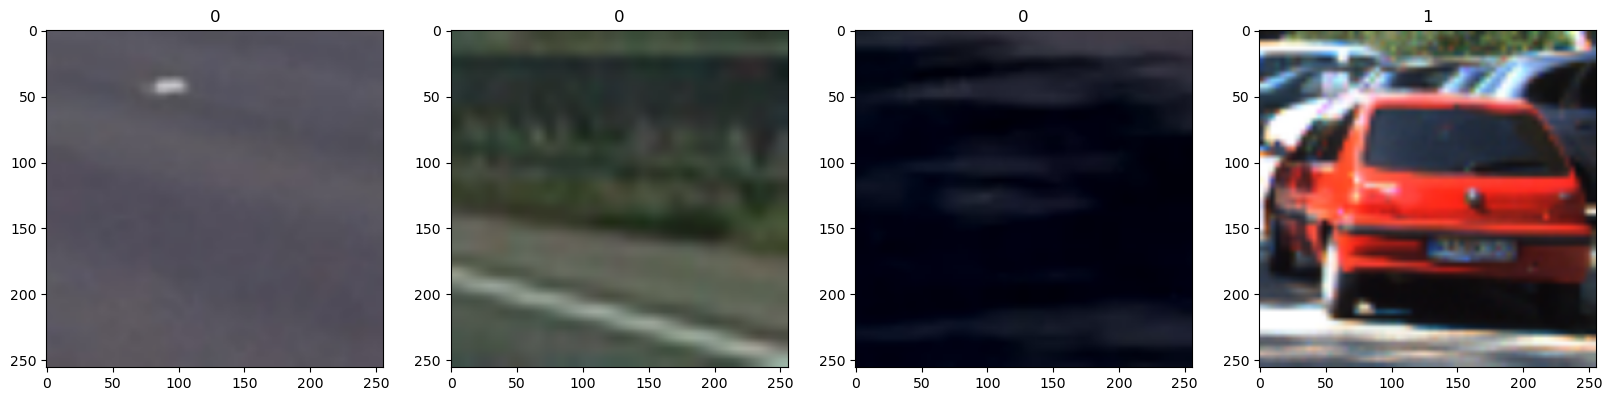

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Preprocesamos la data

In [81]:
# Escalar la data
data = data.map(lambda x,y: (x/255, y))
# x representan nuestras imagenes
# y los labels, 0 o 1 por eso ese no tiene que cambiar

In [82]:
# Obtenemos un lote de nuestra data escalada
batch = data.as_numpy_iterator().next()

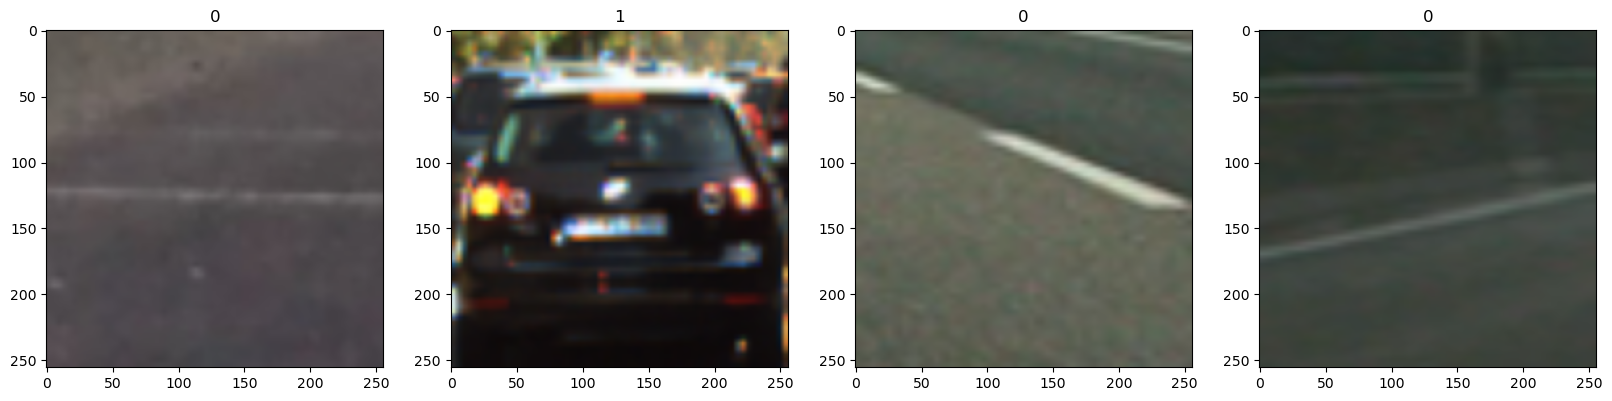

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [84]:
# Veamos el tamaño de nuestra data
len(data)

555

In [85]:
# Dividimos correctamente la data para entrenamiento y testeo
# Usaremos el 70% de nuestra data para entrenamiento
train_size = int(len(data)*.7)
# Usaremos el 20% de nuestra data para validación
val_size = int(len(data)*.2)
#Usaremos el 10% de nuestra data para testearlo
test_size = int(len(data)*.1)+1

In [86]:
train_size + val_size + test_size

555

In [87]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [88]:
len(train) + len(val) + len(test)

555

5.Crear el modelo Deep Learning

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [90]:
model = Sequential()

In [91]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [92]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

6. Entrenar la red neuronal

In [94]:
logdir='logs'

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [96]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
388/388 [==============================] - 20s 50ms/step - loss: 0.5576 - accuracy: 0.8040 - val_loss: 1.1914 - val_accuracy: 0.6757
Epoch 2/3
388/388 [==============================] - 19s 48ms/step - loss: 0.3609 - accuracy: 0.8723 - val_loss: 0.1471 - val_accuracy: 0.9496
Epoch 3/3
388/388 [==============================] - 18s 47ms/step - loss: 4.6046 - accuracy: 0.8102 - val_loss: 5.0267 - val_accuracy: 0.7804


7.Plot Performance

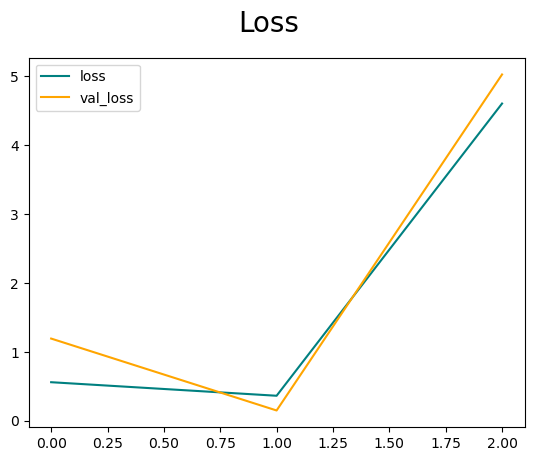

In [97]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

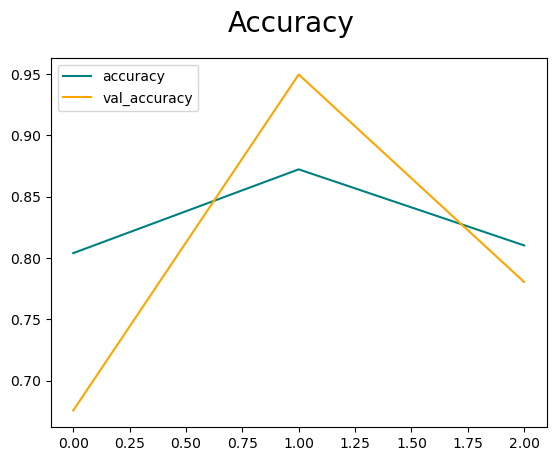

In [98]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

8.Evaluar

In [99]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [100]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [101]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 16ms/step


In [102]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.82578874, shape=(), dtype=float32) tf.Tensor(0.68486917, shape=(), dtype=float32) tf.Tensor(0.7745536, shape=(), dtype=float32)


9.Testear

In [103]:
import cv2

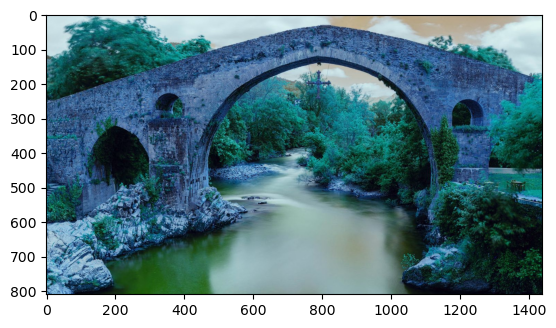

In [104]:
img = cv2.imread('puente.jpg')
plt.imshow(img)
plt.show()

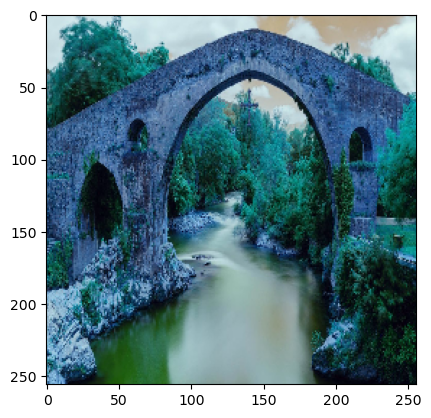

In [105]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [106]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 65ms/step


In [107]:
yhat

array([[6.0366362e-24]], dtype=float32)

In [108]:
if yhat > 0.5: 
    print(f'Predicted class is Vehicle')
else:
    print(f'Predicted class is a Non-vehicle')

Predicted class is a Non-vehicle


10. Guardar el modelo

In [109]:
from tensorflow.keras.models import load_model

In [110]:
# Descomentar la linea de abajo si se desea y cambiar el nombre para guardar el modelo
model.save(os.path.join('models','imageclassifier_for_vehicles.h5'))

In [111]:
new_model = load_model('models/imageclassifier_for_vehicles.h5')

In [118]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 14ms/step


array([[6.0366362e-24]], dtype=float32)

In [117]:

# Cargar el modelo desde el archivo .h5
model = load_model('models/imageclassifier_for_vehicles.h5')



# Convertir el modelo a formato .pb
# model_version = '1'  # Puedes cambiar esto según tu versión del modelo
# export_dir = 'modelo_pb/{}'.format(model_version)

# Guardar el modelo en formato SavedModel
# tf.saved_model.save(model, export_dir)


In [122]:
from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


In [133]:

import tensorflow.keras
rozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

2.12.0


TypeError: Keras symbolic inputs/outputs do not implement `op`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [123]:
# Save to ./model/tf_model.pb
tf.io.write_graph(frozen_graph, "models", "tf_model.pb", as_text=False)

NameError: name 'frozen_graph' is not defined

In [ ]:
import tensorflow as tf
import numpy as np

# Cargar el modelo en formato .pb
pb_model = tf.saved_model.load('modelo_pb/1')
# Leer y preprocesar la imagen de prueba
image_path = 'blanco.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [256, 256])
image = tf.cast(image, tf.float32) / 255.0
input_tensor = tf.expand_dims(image, 0)

# Realizar la inferencia
predictions = pb_model(input_tensor)

# Obtener la clase predicha con el valor decimal completo

predicted_value = predictions[0][predicted_class].numpy()

if predicted_value > 0.5: 
    print(f'Predicted class is Vehicle')
else:
    print(f'Predicted class is a Non-vehicle')

